In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

In [4]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [5]:
# make dataset to input
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [9]:
# hyper parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [11]:
# load data
xy = np.loadtxt("data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order

# split train-test set
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

[[2.53065030e-01 2.45070970e-01 2.33983036e-01 4.66075110e-04
  2.32039560e-01]
 [2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.78314566e-01 1.98470380e-01 5.70171193e-01
  1.78104644e-01]] -> [0.16053716]
[[2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.7831

In [17]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.FC = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.FC(x[:, -1])
        return x

net = Net(data_dim, hidden_dim, output_dim, 1)

In [18]:
# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [19]:
# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

0 0.5927746295928955
1 0.5106987953186035
2 0.43471845984458923
3 0.36347734928131104
4 0.29605790972709656
5 0.23213115334510803
6 0.17236033082008362
7 0.11861536651849747
8 0.07402744144201279
9 0.04269460588693619
10 0.028614047914743423
11 0.033183563500642776
12 0.050680506974458694
13 0.06785740703344345
14 0.07535409182310104
15 0.0724414810538292
16 0.06263803690671921
17 0.050175007432699203
18 0.0384233333170414
19 0.029387488961219788
20 0.023757563903927803
21 0.02125214785337448
22 0.02105475217103958
23 0.022192727774381638
24 0.02378484047949314
25 0.025158552452921867
26 0.02587735280394554
27 0.025721296668052673
28 0.024650363251566887
29 0.022765522822737694
30 0.02027171663939953
31 0.01744195632636547
32 0.014579600654542446
33 0.011977188289165497
34 0.009872949682176113
35 0.008410374633967876
36 0.007610213477164507
37 0.007365468889474869
38 0.007466749753803015
39 0.007656103931367397
40 0.0076957945711910725
41 0.007430178113281727
42 0.0068198200315237045
4

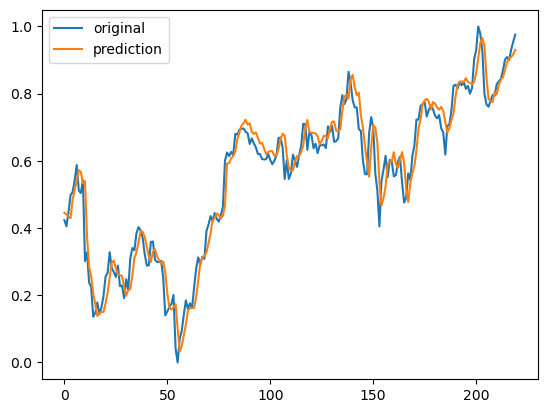

In [20]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()